In [1]:
import os, shutil, pathlib
import torch
#torch 1.10.0
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from datetime import datetime

import numpy as np
import time

import matplotlib.pyplot as plt
#matplotlib 3.3.3
import sklearn
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#sklearn 0.23.2

In [2]:
casez = ["Ext","Loc"]

In [3]:
c = ["Ext","Loc"]

In [4]:
path = pathlib.Path("/home/physics/phubdf/Test_Train_3D")
os.chdir(path)
shutil.rmtree(f"{path}/workspace")
os.mkdir(f"{path}/workspace")

for i in range(0,len(casez)):
    src = os.listdir(f"{path}/{casez[i]}")
    for file in src:
        if file.endswith(".raw"):
            file_name = os.path.join(f"{path}/{casez[i]}", file)
            if os.path.isfile(file_name):
                shutil.copy(file_name, f"{path}/workspace")

In [5]:
shutil.rmtree(f"{path}/labels")
os.mkdir(f"{path}/labels")

for i in range(0,len(casez)):
    csv_input = pd.read_csv(f'{path}/{casez[i]}/labels.csv')
    csv_input.replace(to_replace=0,value=i,inplace = True)
    csv_input.to_csv(f'{path}/labels/labels{c[i]}.csv', index=False)


src = os.listdir(f'{path}/labels')
a = pd.concat([pd.read_csv(f'{path}/labels/{file}') for file in src ], ignore_index=True)
a.to_csv(f'{path}/labels/labels.csv', index=False)


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.loadtxt(f"{img_path}")
        image = np.square(image)
        image = image.reshape(1,20,20,20)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
batch_size = 32

data = CustomImageDataset(annotations_file=f"{path}/labels/labels.csv",img_dir=f"{path}/workspace")
print(len(data))
#Create Validation set
from torch.utils.data import random_split
training_data, validation_data, test_data = random_split(data,[800*len(c),150*len(c),50*len(c)])

# Create data loaders.

train_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

2000


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(train_features)
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels
print(f"Label: {label}")

Feature batch shape: torch.Size([32, 1, 20, 20, 20])
tensor([[[[[1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           ...,
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10]],

          [[1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
           [1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10,
            1.0000e-10, 1.0000e-10],
  

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = models.video.r3d_18()
model.stem[0] = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(3,7,7), stride=(1,2,2), padding=0, bias=False)
model.fc = nn.Linear(in_features=512,out_features=len(c),bias=True)
print(model)

/warwick/desktop/2018/software/PyTorch/1.10.0-fosscuda-2020b/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): B

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [13]:
epochs = 10
min_valid_loss = np.inf
start = time.time()
tl = np.array([])
vl = np.array([])

for e in range(epochs):
    st = time.time()
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = model(data.float())
        loss = loss_fn(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in validation_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data.float())
        loss = loss_fn(target,labels)
        valid_loss = loss.item() * data.size(0)
    
    et = time.time()
    rt = et-st

    print(f'Epoch {e+1} \t Runtime: {round(rt,2)}s \t Training Loss: {train_loss / len(train_dataloader)} \t Validation Loss: {valid_loss / len(validation_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
    else:
        print(" ")
    
    tl = np.append(tl, train_loss / len(train_dataloader))
    vl = np.append(vl,valid_loss / len(validation_dataloader))

end = time.time()
total = end-start
print(f"Total runtime: {round(total,2)}s")

Epoch 1 	 Runtime: 201.71s 	 Training Loss: 0.26087504252791405 	 Validation Loss: 1.0311477899551391
Validation Loss Decreased(inf--->10.311478) 	 Saving The Model
Epoch 2 	 Runtime: 195.84s 	 Training Loss: 0.15085119426250457 	 Validation Loss: 0.21123175621032714
Validation Loss Decreased(10.311478--->2.112318) 	 Saving The Model
Epoch 3 	 Runtime: 190.56s 	 Training Loss: 0.07557884711772203 	 Validation Loss: 0.060194818675518035
Validation Loss Decreased(2.112318--->0.601948) 	 Saving The Model
Epoch 4 	 Runtime: 191.71s 	 Training Loss: 0.03801580645143986 	 Validation Loss: 0.031572628766298294
Validation Loss Decreased(0.601948--->0.315726) 	 Saving The Model
Epoch 5 	 Runtime: 192.13s 	 Training Loss: 0.023573283609002828 	 Validation Loss: 0.020785973221063615
Validation Loss Decreased(0.315726--->0.207860) 	 Saving The Model
Epoch 6 	 Runtime: 192.23s 	 Training Loss: 0.01675653111189604 	 Validation Loss: 0.015385878458619117
Validation Loss Decreased(0.207860--->0.153859

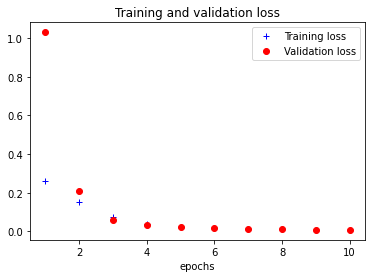

In [14]:
x = np.arange(0,epochs,1)
plt.plot(x+1, tl, "b+", label="Training loss")
np.savetxt(f"tl-E0.1-L0.00001-D20-{datetime.now()}.csv", tl, delimiter=",")
plt.plot(x+1, vl, "ro", label="Validation loss")
np.savetxt(f"vl-E0.1-L0.00001-D20-{datetime.now()}.csv", vl, delimiter=",")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [15]:
predict = []
p = []
model.eval()
for i in range(0,20*len(c)):
    x, y = test_data[i][0], test_data[i][1]
    x = x.reshape(1,1,20,20,20)
    x = torch.from_numpy(x)
    x = x.float()
    with torch.no_grad():
        pred = model (x.cuda()) if torch.cuda.is_available() else model(x)
        predicted, actual = pred[0].argmax(0), y 
        predicted = torch.Tensor.cpu(predicted)
        predict = np.append(predict, predicted)
        p = np.append(p, actual)
      



In [16]:
cm = confusion_matrix(p, predict)
print(cm)
np.savetxt(f"cm-E0.1-L0.00001-D20-{datetime.now()}.csv", cm, delimiter=",")
score = round(accuracy_score(p, predict)*100,2)
print(f"Model Accuracy: {score}%")

[[17  0]
 [ 0 23]]
Model Accuracy: 100.0%
